# RUN MODE

In [1]:
DEV_MODE = False

In [2]:
# hack
! pip install --upgrade --user --quiet seaborn

In [3]:
import pkg_resources
pkg_resources.require("seaborn>=0.9.0")
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
import math
from scipy import stats
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Lasso, LassoCV, SGDClassifier

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline
plt.style.use('bmh')
pd.options.display.max_columns = 100
sns.set()

In [3]:
if DEV_MODE:
    from sklearn.datasets import load_boston
    boston = load_boston()
    boston_df = pd.DataFrame(boston['data'], columns=boston['feature_names'])

# EDA Library

## heatMap(df, abs_cor = 0.4)

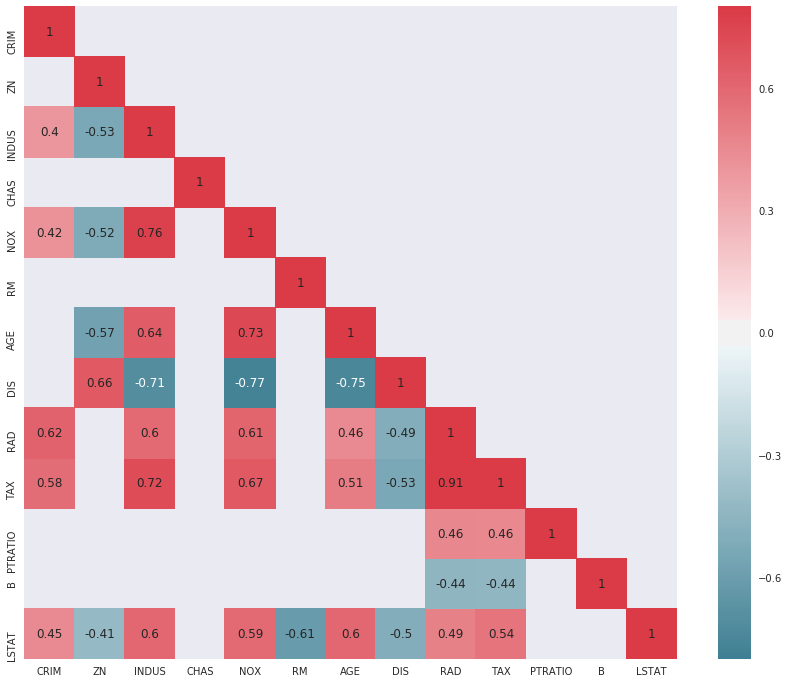

In [4]:
def heatMap(df, abs_cor=0.4):
    corrmat = df.corr()
    plt.subplots(figsize=(15, 12))
    sns.set(font_scale=1)
    mask = np.zeros_like(corrmat, dtype=np.bool)
    mask[np.triu_indices_from(mask, k=1)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(
        corrmat[(corrmat > abs_cor) | (corrmat < -abs_cor)],
        vmax=.8,
        square=True,
        annot=True,
        mask=mask,
        cmap=cmap
    )


if DEV_MODE:
    heatMap(boston_df)

## basicInfo(df)

In [16]:
def basicInfo(df):
  print('shape:', df.shape)
  df.info()
  return df.head()

## getNA(df)

In [5]:
def getNA(dataframe):
    columns = []
    nas = []
    types = []
    at_least_one = False
    for column in list(dataframe):
        hasNA = dataframe[[column]].isna().sum().values
        if (hasNA[0] > 0):
            columns = columns + [column]
            nas = nas + [hasNA[0]]
            types = types + [dataframe[column].dtype]
            at_least_one = True
    if at_least_one == False:
        return 'No NA found'
    return pd.DataFrame({'columns': columns, 'na': nas, 'dtype': types})


if DEV_MODE:
    print(getNA(boston_df))
    boston_df['na'] = None
    print(getNA(boston_df))

No NA found
  columns   dtype   na
0      na  object  506


In [6]:
def getColumnData(df, column):
    if type(column) == int:
        return df.columns[column]
    elif type(column) == str:
        return df[column]
    return column

## singleFieldAnalysis(column, df = None)

count    506.000000
mean      68.574901
std       28.148861
min        2.900000
25%       45.025000
50%       77.500000
75%       94.075000
max      100.000000
Name: AGE, dtype: float64
Na percent: 0.0
Skewness: -0.5989626398812962
Kurtosis: -0.9677155941626912


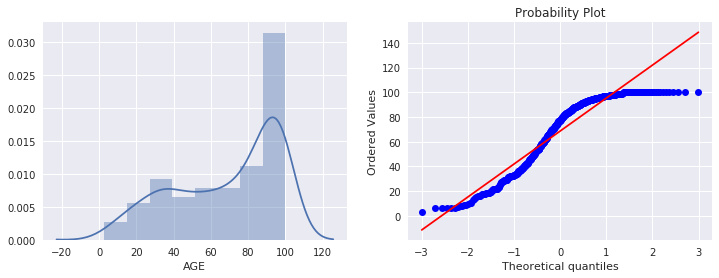

count    506.000000
mean       4.112104
std        0.589774
min        1.360977
25%        3.829184
50%        4.363095
75%        4.554666
max        4.615121
Name: AGE, dtype: float64
Na percent: 0.0
Skewness: -1.5963488063657045
Kurtosis: 2.492209939569602


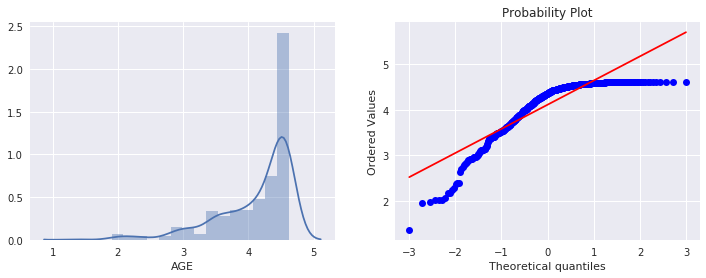

In [7]:
def singleFieldAnalysis(column, df=None):
    column = getColumnData(df, column)
    print(column.describe())
    print("Na percent:", column.isna().sum() / len(column))
    if column.dtype != 'object':
        print("Skewness:", column.dropna().skew())
        print("Kurtosis:", column.dropna().kurt())
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.distplot(column.dropna())
        plt.subplot(1, 2, 2)
        stats.probplot(column, plot=plt)
        plt.show()
    else:
        temp = column.fillna('~none')
        temp = sns.countplot(
            y=temp, order=temp.value_counts().index, color='#bc5090'
        )


if DEV_MODE:
    singleFieldAnalysis('AGE', boston_df)
    singleFieldAnalysis(np.log1p(boston_df['AGE']))

## boxplot(df, columns, label)

In [17]:
def boxplot(df, columns, label):
  fig, axes = plt.subplots(nrows= int(math.floor(len(columns)/2))+1,ncols=2)
  fig.set_size_inches(12, 18)
  sns.boxplot(data=df,y=label,orient="v", ax=axes[0][0])
  for i, column in enumerate(columns):
    sns.boxplot(data=df,y=label,orient="v", x= column, ax=axes[int(math.floor((i+1)/2))][(i+1)%2])

## scatter(df, columns, label)

In [5]:
def scatter(df, columns, label):
  fig, axes = plt.subplots(nrows= int(math.ceil(len(columns)/2)),ncols=2)
  fig.set_size_inches(12, 18)
  for i, column in enumerate(columns):
    sns.scatterplot(data=df,y=label, x= column, ax=axes[int(math.floor(i/2))][i%2])

# ML Library

## doXgbCV(model, train, test, metrics, cv_folds = 5, early_stopping_rounds = 50)

In [9]:
def doXgbCV(model, feature, label, metrics, cv_folds=5, early_stopping_rounds=50):
    xgb_param = model.get_xgb_params()
    xgtrain = xgb.DMatrix(feature.values, label=label.values)
    cvresult = xgb.cv(
        xgb_param,
        xgtrain,
        num_boost_round=model.get_params()['n_estimators'],
        nfold=cv_folds,
        metrics=metrics,
        early_stopping_rounds=early_stopping_rounds
    )
    print(cvresult[['test-rmse-mean', 'test-rmse-std']].tail(1))
    return cvresult

## doLassoCV(feature, label, metrics="neg_mean_squared_error", cv_folds = 5, alpha=1)

In [10]:
def doSklearnCV(
    model, feature, label, metrics="neg_mean_squared_error", cv_folds=5
):
    kf = KFold(
        cv_folds, shuffle=True, random_state=42
    ).get_n_splits(feature.values)
    rmse = np.sqrt(
        -cross_val_score(
            model, feature.values, label.values, scoring=metrics, cv=kf
        )
    )
    print("RMSE Score: {:.4f} ({:.4f})".format(rmse.mean(), rmse.std()))
    return (rmse, model)

In [11]:
def doLassoCV(
    feature, label, metrics="neg_mean_squared_error", cv_folds=5, alpha=1
):
    return doSklearnCV(Lasso(alpha=alpha), feature, label, metrics, cv_folds)

## lassoFeatureImportance(feature, label,  cv=5)
The technique for feature selection using Lasso is highlighted in this [paper](https://beta.vu.nl/nl/Images/werkstuk-fonti_tcm235-836234.pdf)

Best alpha: 0.1
Removed features: Index(['NOX', 'na'], dtype='object')


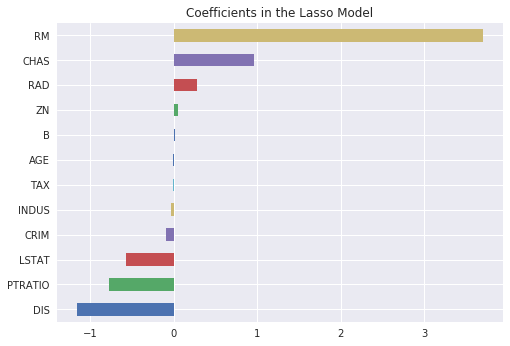

In [12]:
def lassoFeatureImportance(feature, label, cv=5):
    model = LassoCV(alphas=[1, 0.1, 0.001, 0.0005], cv=cv)
    model.fit(feature, label)
    coef = pd.Series(model.coef_, index=feature.columns)
    print('Best alpha:', model.alpha_)
    print('Removed features:', coef[coef == 0].index)
    coef[coef != 0].sort_values().plot(kind="barh")
    plt.title("Coefficients in the Lasso Model")


if DEV_MODE:
    ignore = lassoFeatureImportance(boston_df.fillna(0), boston.target)

# Misc Library

## doGc()

In [13]:
def doGc():
    gc.collect()
    ! free -m

In [3]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:          52333        3857       34039           0       14436       47833
Swap:             0           0           0
